In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.ops as ops
import torch.nn.functional as F
import torchvision.transforms.v2 as v2
import torchvision.transforms as transforms

from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
from einops import rearrange

In [3]:

#### General Parameters ####

IMAGE_SIZE = 256
PATCH_SIZE = 8
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

BERT_FREEZE_LAYERS = 8
MODEL_DIM = 768
LR_BERT = 2e-5
LR_VIT = 2e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

TRAINING = False

In [4]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        
        self.bert = AutoModel.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext")
        
        for name, param in self.bert.named_parameters():
            if 'encoder.layer' in name:
                layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                if layer_num < BERT_FREEZE_LAYERS:
                    param.requires_grad = False
    
    def tokenize(self, texts):
        encoded_text = self.tokenizer(texts, padding=True, truncation=True, 
                                      return_tensors="pt", max_length=128).to(device=DEVICE)

        return encoded_text
    
    def forward(self, encoded_text):
        outputs = self.bert(**encoded_text)
        
        return outputs.last_hidden_state.to(dtype=torch.float32)

In [5]:
class VisionEncoder(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=1,
        embed_dim=MODEL_DIM,
        depths=[2, 2, 2, 2],
        num_heads=12,
    ):
        super(VisionEncoder, self).__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.channels = [embed_dim // 8, embed_dim // 4, embed_dim // 2, embed_dim]

        self.patch_embed = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(
                32,
                embed_dim // 8,
                kernel_size=patch_size,
                stride=patch_size,
            ),
        )

        self.encoders = nn.ModuleList()
        self.upsamplers = nn.ModuleList()
        self.position_embedding = nn.ParameterList(
            [
                nn.Parameter(torch.zeros(1, NUM_PATCHES, d), requires_grad=True)
                for d in self.channels
            ]
        )

        dim = embed_dim // 8
        for i, depth in enumerate(depths):
            self.encoders.append(
                nn.TransformerEncoder(
                    nn.TransformerEncoderLayer(
                        d_model=dim,
                        nhead=num_heads // (2 ** (3 - i)),
                        dim_feedforward=1024,
                        batch_first=True,
                    ),
                    num_layers=depth,
                )
            )

            self.upsamplers.append(
                nn.Sequential(
                    nn.LayerNorm(dim), nn.Linear(in_features=dim, out_features=dim * 2)
                )
                if i < len(depths) - 1
                else nn.Identity()
            )

            dim *= 2

    def forward(self, X):
        X = self.patch_embed(X)  # [B, 96, 32, 32]

        features = []
        for i, (encoder, upsampler, position) in enumerate(
            zip(self.encoders, self.upsamplers, self.position_embedding)
        ):
            X_seq_src = rearrange(X, "b c h w -> b (h w) c")
            X_seq_new = encoder(X_seq_src + position)
            features.append(X_seq_new)
            
            if i < len(self.upsamplers) - 1:
                X = upsampler(X_seq_new + X_seq_src)  # [B, 1024, C*2]
                X = rearrange(
                    X, "b (h w) c -> b c h w", h=self.img_size // self.patch_size
                )

        return features

In [6]:
class VisionDecoder(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        embed_dim=MODEL_DIM,
        num_heads=12,
        dropout=0.1,
        mlp_ratio=3.5,
        output_hidden=2048,
        output_dim=1024,
    ):
        super(VisionDecoder, self).__init__()

        self.img_size = img_size
        self.dropout = dropout
        self.channels = [embed_dim // 8, embed_dim // 4, embed_dim // 2, embed_dim]

        self.cross_attention = nn.ModuleList()
        self.pre_mlp_norm = nn.ModuleList()
        self.post_mlp_norm = nn.ModuleList()
        self.mlp_blocks = nn.ModuleList()
        self.upsamplers = nn.ModuleList()

        for i, dim in enumerate(self.channels):
            self.cross_attention.append(
                nn.MultiheadAttention(
                    embed_dim=dim,
                    num_heads=num_heads // (2 ** (3 - i)),
                    dropout=dropout,
                    kdim=embed_dim,
                    vdim=embed_dim,
                    batch_first=True,
                )
            )

            self.pre_mlp_norm.append(nn.LayerNorm(dim))
            self.post_mlp_norm.append(nn.LayerNorm(dim))
            self.mlp_blocks.append(
                nn.Sequential(
                    nn.Linear(in_features=dim, out_features=int(mlp_ratio * dim)),
                    nn.ReLU(),
                    nn.Linear(in_features=int(mlp_ratio * dim), out_features=dim)
                )
            )

            self.upsamplers.append(
                nn.Sequential(
                    nn.Linear(in_features=dim, out_features=dim * 2), nn.LayerNorm(dim * 2)
                )
                if i < len(self.channels) - 1
                else nn.LayerNorm(dim)
            )

        self.final_mlp = nn.Sequential(
            *[
                nn.Linear(in_features=embed_dim, out_features=output_hidden),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=output_hidden, out_features=output_hidden),
                nn.ReLU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=output_hidden, out_features=output_dim),
                nn.ReLU(),
            ]
        )

    def forward(self, img_features, T):
        features = []
        for i, (attn, pre_norm, post_norm, mlp, upsampler) in enumerate(
            zip(
                self.cross_attention,
                self.pre_mlp_norm,
                self.post_mlp_norm,
                self.mlp_blocks,
                self.upsamplers,
            )
        ):
            src = img_features[i]
            if i > 0:
                src += features[i - 1]

            X, _ = attn(query=src, key=T, value=T, need_weights=False)
        
            X = F.dropout(X, p=self.dropout, training=self.training)
            X = pre_norm(X + src)

            Xff = mlp(X)

            Xff = F.dropout(Xff, p=self.dropout, training=self.training)
            X = post_norm(X + Xff)

            X = upsampler(X)
            features.append(X)

        return self.final_mlp(features[-1])

In [7]:
class VisionOutputHead(nn.Module):
    def __init__(
        self,
        in_dim=1024,
    ):
        super(VisionOutputHead, self).__init__()

        self.binary_output = nn.Sequential(
            *[
                nn.LayerNorm(in_dim),
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=in_dim // 16),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 16, out_features=1),
            ]
        )

        self.count_output = nn.Sequential(
            *[
                nn.LayerNorm(in_dim),
                nn.Linear(in_features=in_dim, out_features=in_dim // 4),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 4, out_features=in_dim // 16),
                nn.GELU(),
                nn.Linear(in_features=in_dim // 16, out_features=1),
            ]
        )

    def forward(self, X):
        binary = self.binary_output(X)
        count = self.count_output(X)

        return binary, count

In [8]:
class MultiModalViT(nn.Module):
    def __init__(
        self,
        img_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        in_channels=1,
        embed_dim=MODEL_DIM,
        encoder_depths=[2, 2, 2, 2],
        output_dim=1024,
    ):
        super(MultiModalViT, self).__init__()
        
        self.text_encoder = TextEncoder()

        self.encoder = VisionEncoder(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim,
            depths=encoder_depths,
        )

        self.decoder = VisionDecoder(
            img_size=img_size, embed_dim=embed_dim, output_dim=output_dim
        )

        self.output = VisionOutputHead(in_dim=output_dim)
    
    def forward(self, imgs, texts):
        text_embeddings = self.text_encoder.tokenize(texts)
        text_embeddings = self.text_encoder(text_embeddings)
        
        features = self.encoder(imgs)
        
        decoded_out = self.decoder(features, text_embeddings)
        binary, count = self.output(decoded_out)
        
        return binary.squeeze(-1), count.squeeze(-1)

In [9]:
import os
import csv
import glob

from data_utils import (
    Datapoint,
    SegmentationDataset,
    generate_labels,
    normalize_images,
    find_mask_center,
    RemoveWhiteLines
)
from typing import List
from PIL import Image


label_map = [
    ("left lung", [44, 47]),
    ("right lung", [45, 46, 48]),
    ("left ribs", list(range(53, 65))),
    ("right ribs", list(range(65, 77))),
    ("vertebraes", list(range(92, 117))),
]

with open("data/training/labels.csv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        skip_row = False
        for struct in ["lung", "rib", "vertebrae"]:
            if struct in row["name"]:
                skip_row = True

        if not skip_row:
            label_map.append((row["name"].replace("_", " "), [int(row["id"]) - 1]))

view_map = {
    "AP": "anteroposterior",
    "LAP": "anteroposterior",
    "RAP": "anteroposterior",
    "PA": "posteroanterior",
    "LPA": "posteroanterior",
    "RPA": "posteroanterior",
    "LLAT": "left lateral",
    "RLAT": "right lateral",
}

In [10]:
matches = glob.glob("data/training/all_ap_pa/**/*.npy", recursive=True)
train_data: List[Datapoint] = []

for i, file_path in enumerate(matches):
    print(f"{i / len(matches) * 100:.2f}% done, {len(train_data)} points.")

    view = view_map[os.path.basename(file_path).rstrip("_labels.npy")]
    name = file_path.rstrip("_labels.npy")

    base = np.asarray(Image.open(f"{name}_base.png").convert("L").getdata())
    if (np.count_nonzero(base) / IMAGE_SIZE**2) < 0.6:
        continue

    base = rearrange(
        torch.tensor(base / 255, dtype=torch.float32),
        "(h w) -> 1 h w",
        h=IMAGE_SIZE,
    ).numpy()

    images = np.load(file_path)[1:]

    for _, (structure, idxs) in enumerate(label_map):
        try:
            mask: np.ndarray = sum([images[i] for i in idxs])
        except IndexError:
            continue

        mask = normalize_images(mask)
        if mask is None:
            continue

        p1 = np.percentile(mask.flatten(), [2])
        mask = (mask > p1).astype(np.float32)

        center = find_mask_center(rearrange(mask * 255, "c h w -> h w c"))
        if center is None or center[1] < 50.0 or center[1] > 200.0:
            continue

        binary, count = generate_labels(mask, patch_size=PATCH_SIZE)
        train_data.append(
            Datapoint(
                base_img=base,
                gt_mask=mask,
                label_binary=binary,
                label_count=count,
                mask_center=center,
                structure=structure,
                view=view,
            )
        )

    if not TRAINING:
        break

0.00% done, 0 points.


In [11]:

matches = glob.glob("data/evaluation/**/*.npy", recursive=True)
mask_transforms = v2.Compose(
    [
        v2.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),
        v2.Resize(
            size=(256, 256), interpolation=v2.InterpolationMode.BICUBIC, antialias=True
        ),
    ]
)

eval_data = []
for i, file_path in enumerate(matches):
    print(file_path)

    name = file_path.rstrip("_mask.npy")

    base = np.asarray(Image.open(f"{name}.png").convert("L").getdata())
    base = rearrange(
        torch.tensor(base / 255, dtype=torch.float32),
        "(h w) -> 1 h w",
        h=200,
    )
    base = v2.Compose(
        [
            v2.CenterCrop(size=190),
            v2.Resize(
                size=(256, 256),
                interpolation=v2.InterpolationMode.BICUBIC,
                antialias=True,
            ),
            v2.Lambda(lambda x: (x * 255).to(dtype=torch.uint8)),
            v2.RandomEqualize(p=1.0),
            v2.Lambda(lambda x: (x / 255).to(dtype=torch.float32)),
            RemoveWhiteLines(dark=0.2, bright=0.8),
            v2.Normalize(mean=[0.5], std=[0.5]),
        ]
    ).forward(base).numpy()

    masks = rearrange(
        torch.tensor(np.load(file_path), dtype=torch.float32), "h w b -> b 1 h w"
    )
    masks = v2.Compose(
        [
            v2.CenterCrop(size=190),
            v2.Resize(
                size=(256, 256),
                interpolation=v2.InterpolationMode.BICUBIC,
                antialias=True,
            ),
        ]
    ).forward(masks).numpy()

    for i, structure in enumerate(["right lung", "left lung", "heart"]):
        p1 = np.percentile(masks[i].flatten(), [2])
        binary, count = generate_labels(mask=(masks[i] > p1), patch_size=PATCH_SIZE)
        eval_data.append(
            Datapoint(
                base_img=base,
                gt_mask=masks[i],
                label_binary=binary,
                label_count=count,
                mask_center=np.array([0, 0]),
                structure=structure,
                view=view_map["AP"],
            )
        )

data/evaluation/JPCLN025_mask.npy
data/evaluation/JPCLN148_mask.npy
data/evaluation/JPCLN019_mask.npy
data/evaluation/JPCLN151_mask.npy
data/evaluation/JPCNN025_mask.npy
data/evaluation/JPCNN044_mask.npy
data/evaluation/JPCLN098_mask.npy
data/evaluation/JPCLN057_mask.npy
data/evaluation/JPCLN113_mask.npy
data/evaluation/JPCLN145_mask.npy
data/evaluation/JPCLN122_mask.npy
data/evaluation/JPCLN142_mask.npy
data/evaluation/JPCLN064_mask.npy
data/evaluation/JPCNN083_mask.npy
data/evaluation/JPCLN090_mask.npy
data/evaluation/JPCNN003_mask.npy
data/evaluation/JPCNN082_mask.npy
data/evaluation/JPCLN069_mask.npy
data/evaluation/JPCLN088_mask.npy
data/evaluation/JPCLN105_mask.npy
data/evaluation/JPCNN079_mask.npy
data/evaluation/JPCNN061_mask.npy
data/evaluation/JPCLN012_mask.npy
data/evaluation/JPCLN112_mask.npy
data/evaluation/JPCLN065_mask.npy
data/evaluation/JPCLN109_mask.npy
data/evaluation/JPCLN149_mask.npy
data/evaluation/JPCLN003_mask.npy
data/evaluation/JPCNN002_mask.npy
data/evaluatio

data/evaluation/JPCNN005_mask.npy
data/evaluation/JPCLN059_mask.npy
data/evaluation/JPCNN091_mask.npy
data/evaluation/JPCNN023_mask.npy
data/evaluation/JPCLN097_mask.npy
data/evaluation/JPCLN131_mask.npy
data/evaluation/JPCNN021_mask.npy
data/evaluation/JPCLN079_mask.npy
data/evaluation/JPCNN064_mask.npy
data/evaluation/JPCNN045_mask.npy
data/evaluation/JPCNN084_mask.npy
data/evaluation/JPCLN101_mask.npy
data/evaluation/JPCNN050_mask.npy
data/evaluation/JPCLN106_mask.npy
data/evaluation/JPCNN065_mask.npy
data/evaluation/JPCNN008_mask.npy
data/evaluation/JPCLN017_mask.npy
data/evaluation/JPCNN059_mask.npy
data/evaluation/JPCNN027_mask.npy
data/evaluation/JPCLN089_mask.npy
data/evaluation/JPCNN076_mask.npy
data/evaluation/JPCLN093_mask.npy
data/evaluation/JPCNN042_mask.npy
data/evaluation/JPCNN039_mask.npy
data/evaluation/JPCNN004_mask.npy
data/evaluation/JPCLN041_mask.npy
data/evaluation/JPCLN007_mask.npy
data/evaluation/JPCLN056_mask.npy
data/evaluation/JPCNN074_mask.npy
data/evaluatio

sternum in a posteroanterior view xray
heart in an anteroposterior view xray
Training Dataset Size: 15; Eval Dataset Size: 738


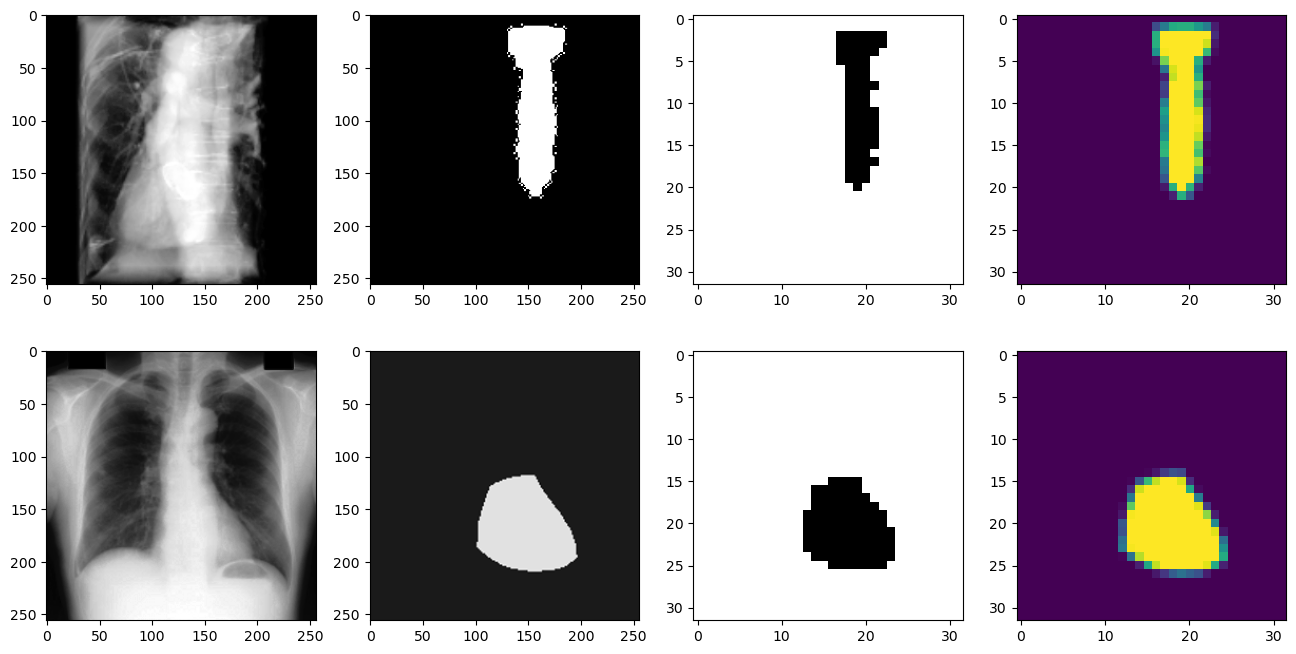

In [12]:
import matplotlib.pyplot as plt


train_dataset = SegmentationDataset(train_data)
eval_dataset = SegmentationDataset(eval_data)


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

prompt, base, binary, count, mask, center = train_dataset.get_random()
axs[0, 0].imshow(rearrange(base.numpy() * 0.5 + 0.5, "c h w -> h w c"), cmap="gray")
axs[0, 1].imshow(rearrange(mask.numpy(), "c h w -> h w c"), cmap="gray")
axs[0, 2].imshow(binary.numpy(), cmap="binary", vmin=0, vmax=1)
axs[0, 3].imshow(count.numpy())

print(train_dataset.sentence_from_tensor(prompt))


prompt, base, binary, count, mask, center = eval_dataset.get_random()
axs[1, 0].imshow(rearrange(base.numpy() * 0.5 + 0.5, "c h w -> h w c"), cmap="gray")
axs[1, 1].imshow(rearrange(mask.numpy(), "c h w -> h w c"), cmap="gray")
axs[1, 2].imshow(binary.numpy(), cmap="binary", vmin=0, vmax=1)
axs[1, 3].imshow(count.numpy())

print(eval_dataset.sentence_from_tensor(prompt))
print(
    f"Training Dataset Size: {len(train_dataset)}; Eval Dataset Size: {len(eval_dataset)}"
)

In [13]:
def get_lr(step, warmup_steps):
    if step < warmup_steps:
        return step / warmup_steps

    return 1.0


def training(
    model: MultiModalViT,
    train_loader: DataLoader,
    eval_loader: DataLoader,
    epochs=20,
    warmup_steps=100,
):
    if not TRAINING:
        return [], []

    model.to(DEVICE)

    text_encoder_params = {
        "params": [p for p in model.text_encoder.parameters() if p.requires_grad]
    }
    other_params = {
        "params": [
            p
            for p in model.parameters()
            if p.requires_grad
            and not any(param is p for param in model.text_encoder.parameters())
        ]
    }

    optimizer = optim.AdamW(
        [
            {**text_encoder_params, "lr": LR_BERT},
            {**other_params, "lr": LR_VIT},
        ],
        weight_decay=0.02,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: get_lr(step, warmup_steps),
    )

    augmentation = v2.RandomAffine(
        degrees=64,
        translate=(0.24, 0.24),
        scale=(0.8, 1.2),
        interpolation=transforms.InterpolationMode.BILINEAR,
    )

    train_losses, val_losses = [], []
    for i in range(epochs):
        model.train()
        train_loss = 0.0

        for j, (prompt, base, _, _, mask, _) in enumerate(train_loader):
            combined = torch.cat([base, mask], dim=0)
            combined = augmentation.forward(combined)
            base, mask = torch.chunk(combined, chunks=2, dim=0)

            base = v2.Compose(
                [
                    v2.RandomErasing(
                        p=0.32, scale=(0.004, 0.008), ratio=(1.0, 1.0), value=0
                    ),
                    v2.Normalize(mean=[0.5], std=[0.5]),
                ]
            ).forward(base)

            binary_label, count_label = generate_labels(
                mask.numpy(), patch_size=PATCH_SIZE
            )
            binary_label = torch.from_numpy(binary_label)
            count_label = torch.from_numpy(count_label)

            texts = []
            for z in range(prompt.shape[0]):
                texts.append(train_dataset.sentence_from_tensor(prompt[z]))

            base = base.to(DEVICE, dtype=torch.float32)
            binary_label = binary_label.flatten(start_dim=1).to(
                DEVICE, dtype=torch.float32
            )
            count_label = count_label.flatten(start_dim=1).to(
                DEVICE, dtype=torch.float32
            )

            #############################

            binary, count = model(base, texts)
            binary_prob = torch.sigmoid(binary)

            bce_loss = ops.focal_loss.sigmoid_focal_loss(
                binary, binary_label, gamma=2.2, alpha=0.6, reduction="mean"
            )
            mse_loss = F.mse_loss(count, count_label)

            confidence = torch.max(binary_prob, 1 - binary_prob)
            diff = torch.abs(binary_prob - torch.clamp(count / PATCH_SIZE**2, min=0.0, max=1.0))
            consistency_loss = (diff * confidence).mean()

            loss = bce_loss + 0.6 * mse_loss + 0.8 * consistency_loss
            train_loss += loss.item()
            if j % 20 == 0:
                print(
                    f"Epoch {i}; Batch {j} : bce={bce_loss.item():.4f}, mse={mse_loss.item():.4f}, consist={consistency_loss.item():.4f}, total={loss.item():.4f}"
                )

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

        #######################################################################################

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for j, (prompt, base, binary_label, count_label, _, _) in enumerate(
                eval_loader
            ):
                texts = []
                for z in range(prompt.shape[0]):
                    texts.append(eval_dataset.sentence_from_tensor(prompt[z]))

                base = base.to(DEVICE, dtype=torch.float32)
                binary_label = binary_label.flatten(start_dim=1).to(
                    DEVICE, dtype=torch.float32
                )
                count_label = count_label.flatten(start_dim=1).to(
                    DEVICE, dtype=torch.float32
                )

                #############################

                binary, count = model(base, texts)
                binary_prob = torch.sigmoid(binary)

                bce_loss = ops.focal_loss.sigmoid_focal_loss(
                    binary, binary_label, gamma=2.2, alpha=0.6, reduction="mean"
                )
                mse_loss = F.mse_loss(count, count_label)

                confidence = torch.max(binary_prob, 1 - binary_prob)
                diff = torch.abs(binary_prob - torch.clamp(count / PATCH_SIZE**2, min=0.0, max=1.0))
                consistency_loss = (diff * confidence).mean()

                loss = bce_loss + 0.6 * mse_loss + 0.8 * consistency_loss
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(eval_loader)

        print(
            f"Epoch {i}; : training loss={train_loss:.4f}, validation loss={val_loss:.4f}"
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (i + 1) % 2 == 0:
            torch.save(model.state_dict(), f"checkpoints/vit_v2_epoch{i+1}.pt")

    return train_losses, val_losses

In [14]:
model = MultiModalViT(
    img_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=1,
    embed_dim=MODEL_DIM,
    encoder_depths=[2, 2, 4, 6],
    output_dim=1024
)
model.load_state_dict(torch.load('checkpoints/vit_v0_epoch50.pt', weights_only=True))
model.to(DEVICE)

print(f"Total Model Parameters: ~{sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6:.2f}mil")

2025-05-13 06:56:26.366751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 06:56:26.378335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747119386.397022   86109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747119386.400674   86109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-13 06:56:26.415681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Total Model Parameters: ~103.67mil


In [15]:
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True
)

eval_loader = DataLoader(
    dataset=eval_dataset, batch_size=8, shuffle=True, pin_memory=True
)


train_losses, val_losses = training(
    model=model,
    train_loader=train_loader,
    eval_loader=eval_loader,
    epochs=8,
    warmup_steps=200,
)

In [16]:
if TRAINING:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Training Loss")

    axs[1].plot(val_losses)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Validation Loss")

    fig.show(warn=False)
else:
    pass

In [17]:
def flood_fill_pruning(mask: np.ndarray, threshold=0.6):
    mask = (mask > threshold).astype(np.int32)
    H, W = mask.shape

    visited: set[tuple[int, int]] = set()
    stack: list[tuple[int, int]] = []

    component_max = ([], -1)

    for i in range(H):
        for j in range(W):
            if mask[i, j] == 0:
                continue

            stack.append((i, j))
            visited.add((i, j))
            component = []

            while len(stack) > 0:
                r, c = stack.pop()
                component.append((r, c))

                for dr, dc in [
                    (-1, 0),
                    (0, -1),
                    (0, 1),
                    (1, 0),
                ]:
                    rr = r + dr
                    cc = c + dc

                    if (
                        (rr < 0 or rr >= H)
                        or (cc < 0 or cc >= W)
                        or (rr, cc) in visited
                        or mask[rr, cc] == 0
                    ):
                        continue

                    stack.append((rr, cc))
                    visited.add((rr, cc))

            if len(component) > component_max[1]:
                component_max = (component, len(component))

    return component_max[0]


def remove_protrusions(binary: np.ndarray, threshold=2):
    H, W = binary.shape

    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    new_image = np.zeros_like(binary)

    padded = np.pad(binary, pad_width=1, mode="constant", constant_values=0)

    for i in range(1, H + 1):
        for j in range(1, W + 1):
            new_image[i - 1, j - 1] = binary[i - 1, j - 1]

            if binary[i - 1, j - 1] > 0:
                window = padded[i - 1 : i + 2, j - 1 : j + 2]
                result = np.sum(window * kernel)

                if result >= threshold:
                    new_image[i - 1, j - 1] = 0

    return new_image


def inpaint_missing(binary: np.ndarray):
    H, W = binary.shape

    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    new_image = np.zeros_like(binary)

    padded = np.pad(binary, pad_width=1, mode="constant", constant_values=0)

    for i in range(1, H + 1):
        for j in range(1, W + 1):
            new_image[i - 1, j - 1] = binary[i - 1, j - 1]

            if binary[i - 1, j - 1] == 0:
                window = padded[i - 1 : i + 2, j - 1 : j + 2]
                result = np.sum(window * kernel)

                if result >= 4:
                    new_image[i - 1, j - 1] = 1

    return new_image


def remove_uncertain_regions(binary: np.ndarray):
    H, W = binary.shape

    padded = np.pad(binary, pad_width=1, mode="constant", constant_values=0)
    new_image = np.zeros_like(padded)

    for i in range(1, H + 1):
        for j in range(1, W + 1):
            new_image[i - 1, j - 1] = binary[i - 1, j - 1]

            if binary[i - 1, j - 1] > 0:
                window = padded[i - 1 : i + 2, j - 1 : j + 2]
                
                if np.count_nonzero(window > 0.9) <= 6:  
                    new_image[i - 1 : i + 2, j - 1 : j + 2] = 0

    return new_image[1:-1, 1:-1]

In [18]:
model.eval()
overall_eval_loss = 0

for _, (prompt, base, binary_label, count_label, mask, _) in enumerate(eval_dataset):
    with torch.no_grad():
        texts = [eval_dataset.sentence_from_tensor(prompt)]

        base = base.unsqueeze(0).to(DEVICE, dtype=torch.float32)
        binary_label = (
            binary_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
        )
        count_label = (
            count_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
        )

        ##########################################################

        binary, count = model(base, texts)
        binary_prob = torch.sigmoid(binary)

        binary_loss = F.mse_loss(binary, binary_label)
        count_loss = F.mse_loss(count, count_label)

        loss = (binary_loss + count_loss) / 2.0
        if "lung" in texts[0]:
            loss *= 0.8
        overall_eval_loss += loss.item()


print(f"Average Evaluation Loss: {overall_eval_loss/len(eval_dataset):.4f}")

Average Evaluation Loss: 152.3690


Loss: 24.3877


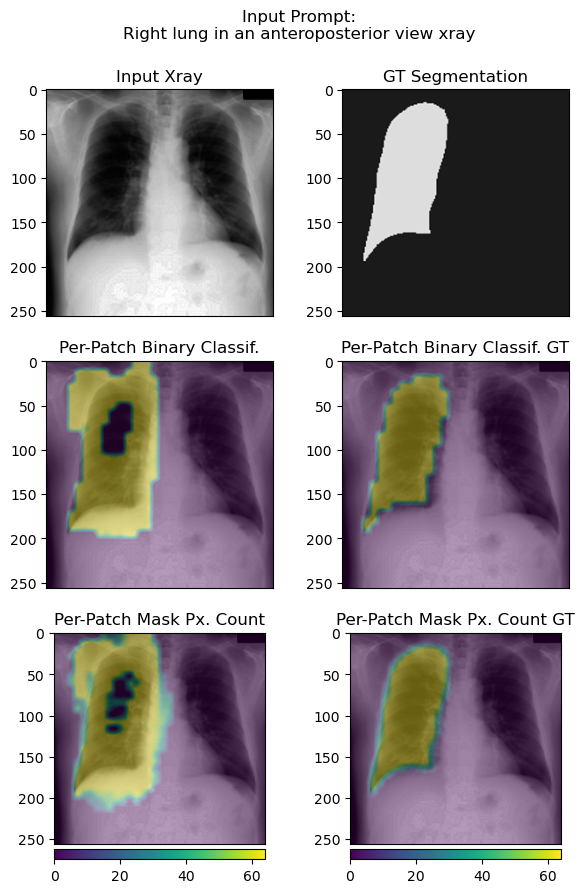

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

model.eval()

with torch.no_grad():
    prompt, base, binary_label, count_label, mask, _ = eval_dataset.get_random(structure='lung')

    texts = [eval_dataset.sentence_from_tensor(prompt)]

    base = base.unsqueeze(0).to(DEVICE, dtype=torch.float32)
    binary_label = (
        binary_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
    )
    count_label = (
        count_label.unsqueeze(0).flatten(start_dim=1).to(DEVICE, dtype=torch.float32)
    )

    ##########################################################

    binary, count = model(base, texts)
    binary_prob = torch.sigmoid(binary)

    binary_loss = F.mse_loss(binary, binary_label)
    count_loss = F.mse_loss(count / PATCH_SIZE**2, count_label / PATCH_SIZE**2)

    loss = (binary_loss + count_loss) / 2.0
    print(f"Loss: {loss.item():.4f}")

    patches = IMAGE_SIZE // PATCH_SIZE

    binary = F.sigmoid(binary).reshape(patches, patches).cpu().detach().numpy()
    count = torch.clamp(count, min=0.0, max=PATCH_SIZE**2)
    count = count.reshape(patches, patches).cpu().detach().numpy()

    binary_label = binary_label.reshape(patches, patches).cpu().detach().numpy()
    count_label = count_label.reshape(patches, patches).cpu().detach().numpy()

    base = base.cpu().detach().numpy()
    base = rearrange(
        base,
        "b c h w -> h w (b c)",
    )

    mask = mask.cpu().detach().numpy()
    mask = rearrange(mask, "c h w -> h w c")

    binary_idxs = flood_fill_pruning(binary, threshold=0.80)
    count_idxs = flood_fill_pruning(count, threshold=count.mean())

    for r in range(patches):
        for c in range(patches):
            if (r, c) not in binary_idxs:
                binary[r, c] = 0.0

            if (r, c) not in count_idxs:
                count[r, c] = 0.0

    binary = inpaint_missing(binary)
    binary = remove_protrusions(binary, threshold=2.0)

    binary = (
        v2.Resize(
            size=(IMAGE_SIZE, IMAGE_SIZE),
            interpolation=transforms.InterpolationMode.BICUBIC,
        )
        .forward(torch.tensor(binary).unsqueeze(0))
        .squeeze()
    )

    count = (
        v2.Resize(
            size=(IMAGE_SIZE, IMAGE_SIZE),
            interpolation=transforms.InterpolationMode.BICUBIC,
        )
        .forward(torch.tensor(count).unsqueeze(0))
        .squeeze()
    )

    binary_label = (
        v2.Resize(
            size=(IMAGE_SIZE, IMAGE_SIZE),
            interpolation=transforms.InterpolationMode.BICUBIC,
        )
        .forward(torch.tensor(binary_label).unsqueeze(0))
        .squeeze()
    )

    count_label = (
        v2.Resize(
            size=(IMAGE_SIZE, IMAGE_SIZE),
            interpolation=transforms.InterpolationMode.BICUBIC,
        )
        .forward(torch.tensor(count_label).unsqueeze(0))
        .squeeze()
    )


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 10))
fig.suptitle(f"Input Prompt:\n{texts[0].capitalize()}", y=0.96)
for i in range(3):
    for j in range(2):
        axs[i, j].tick_params(
            axis="x",
            which="both",
            bottom=False,
            top=False,
            labelbottom=False,
        )

axs[0, 0].set_title("Input Xray")
axs[0, 0].imshow(base, cmap="gray")
axs[0, 1].set_title("GT Segmentation")
axs[0, 1].imshow(mask, cmap="gray")

axs[1, 0].set_title("Per-Patch Binary Classif.")
axs[1, 0].imshow(binary, cmap="viridis", vmin=0.25, vmax=1)
axs[1, 0].imshow(base, cmap="gray", alpha=0.6)
axs[1, 1].set_title("Per-Patch Binary Classif. GT")
axs[1, 1].imshow(
    binary_label,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
axs[1, 1].imshow(base, cmap="gray", alpha=0.6)

axs[2, 0].set_title("Per-Patch Mask Px. Count")
h = axs[2, 0].imshow(count, vmin=0, vmax=PATCH_SIZE**2)
axs[2, 0].imshow(base, cmap="gray", alpha=0.6)
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
fig.colorbar(h, cax=cax, orientation="horizontal")

axs[2, 1].set_title("Per-Patch Mask Px. Count GT")
h = axs[2, 1].imshow(count_label, vmin=0, vmax=PATCH_SIZE**2)
axs[2, 1].imshow(base, cmap="gray", alpha=0.6)
divider = make_axes_locatable(axs[2, 0])
cax = divider.append_axes("bottom", size="5%", pad=0.05)
fig.colorbar(h, cax=cax, orientation="horizontal")

fig.show(warn=False)